# Monte Carlo Prediction

The goal is to learn the state-value function for a given policy $v_{\pi}(s)$ by estimating it using Monte Carlo (MC) methods. The first-visit MC method estimates $v_{\pi}(s)$ as the average of the returns following all first visits to $s$. The every-visit MC method is largely the same, the only exception being that there is no check that the state has occurred earlier in the episode.

[<img src="../Pseudocodes/first-visit_mc_prediction.png" width="600"/>](../Pseudocodes/fist-visit_mc_prediction.png)

In this notebook, we will be running MC Prediction on the game of Blackjack.

In [11]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import sys

from collections import defaultdict

In [12]:
blackjack_env = gym.make("Blackjack-v1", natural=False, sab=False)

In [13]:
def first_visit_mc_prediction(pi, env, num_eps, gamma=1.0):
    """
    First-visit Monte Carlo prediction algorithm
    
    Args:
        pi: policy function that takes state and returns action probabilities
        env: environment
        num_eps: number of episodes to run
        gamma: discount factor
    
    Returns:
        V: state-value function
    """
    returns = defaultdict(list)
    V = defaultdict(float)

    for eps in range(1, num_eps + 1):
        if eps % 100 == 0:
            print("\rEpisode {}/{}.".format(eps, num_eps), end="")
            sys.stdout.flush()
        
        # Generate an episode
        episode = list()
        state, _ = env.reset()
        
        while True:
            # Choose action according to policy
            action = pi(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            
            if terminated or truncated:
                break
            state = next_state
        
        # Calculate returns and update value function for first visits
        G = 0
        visited_states = set()
        
        # Process episode in reverse order
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            
            # First-visit MC: only update if this is the first time we see this state in this episode
            if state not in visited_states:
                visited_states.add(state)
                returns[state].append(G)
                V[state] = sum(returns[state]) / len(returns[state])

    return V

In [ ]:
def every_visit_mc_prediction(pi, env, num_eps, gamma=1.0):
    """
    Every-visit Monte Carlo prediction algorithm
    
    Args:
        pi: policy function that takes state and returns action probabilities
        env: environment
        num_eps: number of episodes to run
        gamma: discount factor
    
    Returns:
        V: state-value function
    """
    returns = defaultdict(list)
    V = defaultdict(float)

    for eps in range(1, num_eps + 1):
        if eps % 100 == 0:
            print("\rEpisode {}/{}.".format(eps, num_eps), end="")
            sys.stdout.flush()
        
        # Generate an episode
        episode = list()
        state, _ = env.reset()
        
        while True:
            # Choose action according to policy
            action = pi(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            
            if terminated or truncated:
                break
            state = next_state
        
        # Calculate returns and update value function for first visits
        G = 0
        
        # Process episode in reverse order
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            
            # Every-visit MC: always update
            returns[state].append(G)
            V[state] = sum(returns[state]) / len(returns[state])

    return V

In [15]:
def simple_policy(state):
    """
    Simple policy for Blackjack: stick if sum >= 20, otherwise hit
    
    Args:
        state: tuple of (player_sum, dealer_card, usable_ace)
    
    Returns:
        action: 0 (stick) or 1 (hit)
    """
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 20 else 1


In [16]:
def advanced_policy(state):
    player_sum, dealer_card, usable_ace = state
    if usable_ace and player_sum <= 20:
        return 0
    elif not usable_ace and player_sum < 18:
        return 1
    else:
        return 0

In [ ]:
# Create a heatmap of state values
def plot_state_values(V):
    # Extract states with usable ace and without usable ace
    usable_ace_states = {}
    no_usable_ace_states = {}
    
    for state, value in V.items():
        player_sum, dealer_card, usable_ace = state
        if usable_ace:
            usable_ace_states[(player_sum, dealer_card)] = value
        else:
            no_usable_ace_states[(player_sum, dealer_card)] = value
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot without usable ace
    if no_usable_ace_states:
        player_sums = sorted(set(s[0] for s in no_usable_ace_states.keys()))
        dealer_cards = sorted(set(s[1] for s in no_usable_ace_states.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), value in no_usable_ace_states.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = value
        
        im1 = ax1.imshow(matrix, cmap='RdYlBu_r', aspect='auto')
        ax1.set_title('State Values (No Usable Ace)')
        ax1.set_xlabel('Dealer Card')
        ax1.set_ylabel('Player Sum')
        ax1.set_xticks(range(len(dealer_cards)))
        ax1.set_xticklabels(dealer_cards)
        ax1.set_yticks(range(len(player_sums)))
        ax1.set_yticklabels(player_sums)
        plt.colorbar(im1, ax=ax1)
    
    # Plot with usable ace
    if usable_ace_states:
        player_sums = sorted(set(s[0] for s in usable_ace_states.keys()))
        dealer_cards = sorted(set(s[1] for s in usable_ace_states.keys()))
        
        matrix = np.zeros((len(player_sums), len(dealer_cards)))
        for (ps, dc), value in usable_ace_states.items():
            i = player_sums.index(ps)
            j = dealer_cards.index(dc)
            matrix[i, j] = value
        
        im2 = ax2.imshow(matrix, cmap='RdYlBu_r', aspect='auto')
        ax2.set_title('State Values (With Usable Ace)')
        ax2.set_xlabel('Dealer Card')
        ax2.set_ylabel('Player Sum')
        ax2.set_xticks(range(len(dealer_cards)))
        ax2.set_xticklabels(dealer_cards)
        ax2.set_yticks(range(len(player_sums)))
        ax2.set_yticklabels(player_sums)
        plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

In [18]:
# Test the First-visit MC prediction algorithm
print("Running First-visit MC Prediction on Blackjack...")
V_first = first_visit_mc_prediction(advanced_policy, blackjack_env, num_eps=50000)
print(f"\nCompleted! Learned values for {len(V_first)} states.")

# Display some example state values
print("\nSample state values:")
for i, (state, value) in enumerate(list(V_first.items())[:10]):
    print(f"State {state}: {value:.3f}")


Running First-visit MC Prediction on Blackjack...
Episode 100/50000.

Episode 50000/50000.
Completed! Learned values for 280 states.

Sample state values:
State (20, 8, 0): 0.799
State (10, 8, 0): 0.241
State (18, 5, 0): 0.154
State (14, 5, 0): -0.300
State (12, 5, 0): -0.370
State (12, 9, 0): -0.404
State (19, 10, 0): -0.002
State (18, 6, 0): 0.263
State (15, 10, 0): -0.564
State (15, 8, 0): -0.485


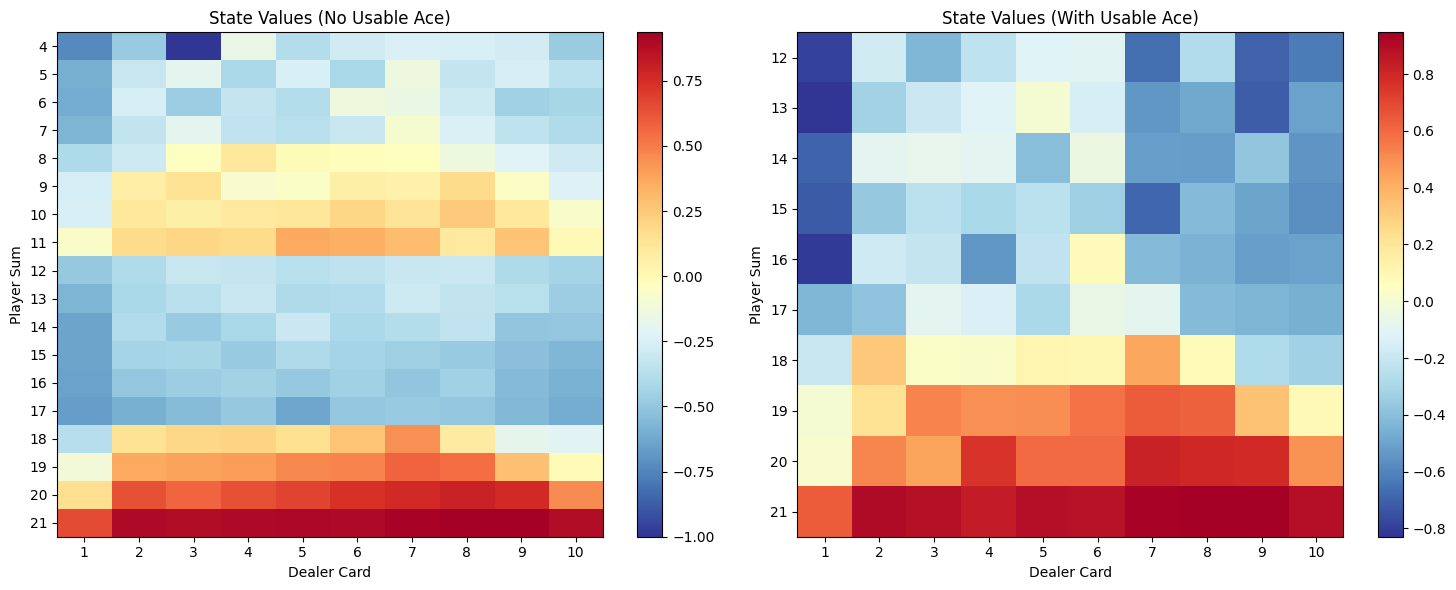

In [19]:
plot_state_values(V_first)

In [20]:
# Test the Every-visit MC prediction algorithm
print("Running Every-visit MC Prediction on Blackjack...")
V_every = every_visit_mc_prediction(advanced_policy, blackjack_env, num_eps=50000)
print(f"\nCompleted! Learned values for {len(V_every)} states.")

# Display some example state values
print("\nSample state values:")
for i, (state, value) in enumerate(list(V_every.items())[:10]):
    print(f"State {state}: {value:.3f}")


Running Every-visit MC Prediction on Blackjack...
Episode 50000/50000.
Completed! Learned values for 280 states.

Sample state values:
State (19, 4, 0): 0.380
State (14, 4, 0): -0.402
State (19, 2, 1): 0.164
State (16, 10, 0): -0.569
State (15, 7, 0): -0.396
State (14, 10, 0): -0.509
State (20, 7, 0): 0.802
State (12, 7, 0): -0.264
State (17, 10, 0): -0.600
State (21, 1, 0): 0.574


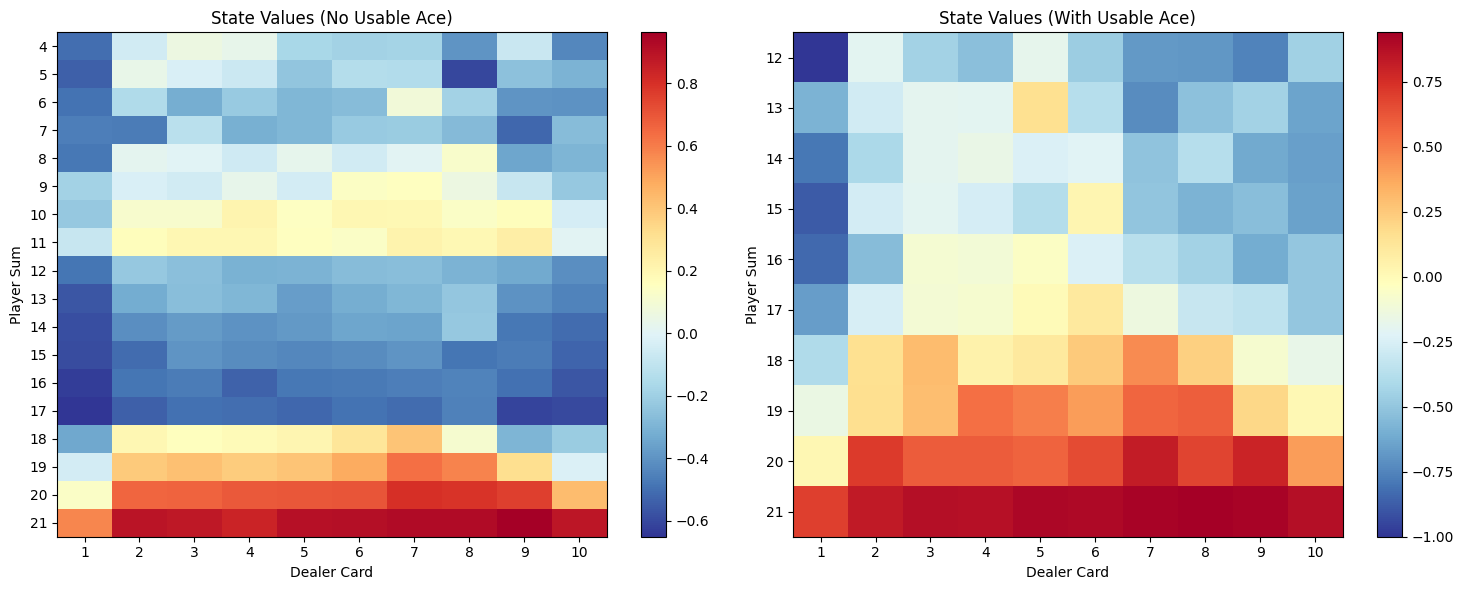

In [21]:
plot_state_values(V_every)